In [1]:
import logging
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.layers as kl
import tensorflow.keras.losses as kls
import tensorflow.keras.optimizers as ko
from pathlib import Path
import ruamel.yaml as yaml
from tqdm.notebook import tqdm
import scipy.stats as stats
import pandas as pd
import ray
from ray import tune
import tensorflow.keras as keras
from tensorflow.keras.callbacks import ModelCheckpoint
import shutil
%matplotlib inline

print("TensorFlow Ver: ", tf.__version__)

TensorFlow Ver:  2.1.0


In [2]:
seed = 1234
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [4]:
# Eager by default!
print("Eager Execution:", tf.executing_eagerly())
print("1 + 2 + 3 + 4 + 5 =", tf.reduce_sum([1, 2, 3, 4, 5]))

Eager Execution: True
1 + 2 + 3 + 4 + 5 = tf.Tensor(15, shape=(), dtype=int32)


In [5]:
class dependent_bandit():
    def __init__(self, difficulty):
        self.num_actions = 2
        self.n_timesteps = 100
        self.difficulty = difficulty
        self.reset()
        
    def set_restless_prob(self):
        self.bandit = np.array([self.restless_list[self.timestep],1 - self.restless_list[self.timestep]])
        
    def reset(self):
        self.timestep = 0
        if self.difficulty == 'restless': 
            variance = np.random.uniform(0,.5)
            self.restless_list = np.cumsum(np.random.uniform(-variance,variance,(150,1)))
            self.restless_list = (self.restless_list - np.min(self.restless_list)) / (np.max(self.restless_list - np.min(self.restless_list))) 
            self.set_restless_prob()
        if self.difficulty == 'easy': 
            bandit_prob = np.random.choice([0.9,0.1])
        if self.difficulty == 'trivial': 
            bandit_prob = np.random.choice([1.0,0.0])
        if self.difficulty == 'medium': 
            bandit_prob = np.random.choice([0.75,0.25])
        if self.difficulty == 'hard':  
            bandit_prob = np.random.choice([0.6,0.4])
        if self.difficulty == 'uniform': 
            bandit_prob = np.random.uniform()
        if self.difficulty != 'independent' and self.difficulty != 'restless':
            self.bandit = np.array([bandit_prob,1 - bandit_prob])
        else:
            self.bandit = np.random.uniform(size=2)
        
    def step(self,action):
        #Get a random number.
        if self.difficulty == 'restless': 
            self.set_restless_prob()
        self.timestep += 1
        bandit = self.bandit[int(action)]
        result = np.random.uniform()
        if result < bandit:
            #return a positive reward.
            reward = 1
        else:
            #return a negative reward.
            reward = 0
        if self.timestep > self.n_timesteps - 1: 
            done = True
        else: 
            done = False
        return reward, done, self.timestep

In [6]:
class GaussBandit(dependent_bandit):
    def __init__(self, difficulty, scale = 0.5):
        super().__init__(difficulty)
        self.scale = scale
        
    def step(self, action):
        if self.difficulty == 'restless': 
            self.set_restless_prob()
        self.timestep += 1
        bandit = self.bandit[int(action)]
        reward = stats.norm.rvs(loc=bandit, scale=self.scale)
        
        if self.timestep > self.n_timesteps - 1: 
            done = True
        else: 
            done = False
        
        return reward, done, self.timestep
        
g = GaussBandit('easy')
print(g.bandit)
g.step(1)

[0.1 0.9]


(1.5730627001754955, False, 1)

In [7]:
class ThompsonAgent:
    def __init__(self, env_name):
        self.env = dependent_bandit(env_name)
        self.reset()
    
    def reset(self):
        self.pulls = np.zeros(2)
        #sampled mean of an arm
        self.mean = np.zeros(2)
        #beta for use in thompson sampling
        self.beta = np.ones((2,2))
        self.env.reset()
    
    def pull(self, arm):
        self.pulls[arm] += 1
        r, done, timestep = self.env.step(arm)
        self.update_mean(arm, r)
        self.update_beta(arm, r)
        return r, done, timestep
    
    def update_mean(self, arm, r):
        n = self.pulls[arm]
#         m = self.mean[arm]
        self.mean[arm] = (n-1)/n*self.mean[arm] + r/n
    
    def update_beta(self, arm, r):
        self.beta[arm] += np.array([r, 1-r])
    
    def change_env(self, env):
        self.env = env
        self.reset()
    
    def predict(self):
        return np.argmax([np.random.beta(self.beta[0][0], self.beta[0][1]), np.random.beta(self.beta[1][0], self.beta[1][1])])
    
    def play(self, n):
        self.reset()
        r_hist = np.empty(n)
        a_hist = np.empty(n)
        mean_hist = np.empty((2,n+1))
        mean_hist[:,0] = self.mean
        beta_hist = np.empty((2, n+1, 2))
        beta_hist[:,0,:] = self.beta
        for i in range(n):
            j = self.predict()
            a_hist[i] = j
            r_hist[i], _, _ = self.pull(j)
            beta_hist[:,i+1,:] = self.beta
            mean_hist[:,i+1] = self.mean
        return a_hist, r_hist, beta_hist, mean_hist

    def benchmark(self, n_episodes = 300, n_timesteps = 100):
        #for now n_timesteps will be 100 since that is the value in the dependent env
        actions = np.empty((n_episodes, n_timesteps))
        rewards = np.empty((n_episodes, n_timesteps))
        bandits = np.empty((n_episodes, 2))
        for i in range(n_episodes):
            a, r, _, _ = self.play(n_timesteps)
            bandits[i] = self.env.bandit
            actions[i] = a
            rewards[i] = r
        return {'actions': actions, 'rewards': rewards, 'env': self.env, 'bandits': bandits}

In [8]:
class GaussThompson:
    def __init__(self, env_name, tau = 1):
        self.env = GaussBandit(env_name)
        self.tau = tau
    
    def reset(self):
        self.pulls = np.zeros(2)
        self.mean = np.zeros(2)
        self.lambd = np.ones(2)
        self.env.reset()
        
    def pull(self, arm):
        self.pulls[arm] += 1
        r, done, timestep = self.env.step(arm)
        self.update_variables(arm, r)
        return r, done, timestep

    def update_variables(self, arm, r):
        self.mean[arm] = 1/(self.tau*self.pulls[arm]+1)*(self.tau*r + (self.tau*(self.pulls[arm]-1)+1)*self.mean[arm])
        self.lambd[arm] = self.tau + self.lambd[arm]
    
    def predict(self):
        return np.argmax([np.random.normal(self.mean[0], np.sqrt(1/self.lambd[0])), np.random.normal(self.mean[1], np.sqrt(1/self.lambd[1]))])
    
    def play(self, n):
        self.reset()
        r_hist = np.empty(n)
        a_hist = np.empty(n)
        mean_hist = np.empty((2,n+1))
        mean_hist[:,0] = self.mean
        lambda_hist = np.empty((2, n+1))
        lambda_hist[:,0] = self.lambd
        for i in range(n):
            action = self.predict()
            a_hist[i] = action
            r_hist[i], _, _ = self.pull(action)
            lambda_hist[:,i+1] = self.lambd
            mean_hist[:,i+1] = self.mean
        return a_hist, r_hist, lambda_hist, mean_hist

    def benchmark(self, n_episodes = 300, n_timesteps = 100):
        #for now n_timesteps will be 100 since that is the value in the dependent env
        actions = np.empty((n_episodes, n_timesteps))
        rewards = np.empty((n_episodes, n_timesteps))
        bandits = np.empty((n_episodes, n_timesteps))
        for i in range(n_episodes):
            a, r, _, _ = self.play(n_timesteps)
            bandits[i] = self.env.bandit
            actions[i] = a
            rewards[i] = r
        return {'actions': actions, 'rewards': rewards, 'env': self.env, 'bandits': bandits}

array([0.57670146, 0.42329854])

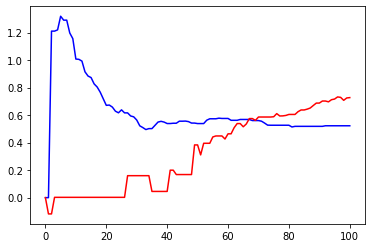

In [9]:
gauss = GaussThompson('restless')
a,  r, l, m = gauss.play(100)
plt.plot(m[0], 'b')
plt.plot(m[1], 'r')
gauss.env.bandit

In [10]:
bandit = dependent_bandit('uniform')

In [11]:
bandit.reset()

In [12]:
bandit.step(0)

(1, False, 1)

In [13]:
class Model(tf.keras.Model):
    def __init__(self, num_actions, batch_size=1, n_timesteps=None, n_features=4, name='meta_policy'):
        super().__init__(name)
#         Having a stateful LSTM means that you will need to reset the hidden state 
#         in between batches yourself if you do want independent batches. 
#         The default initial hidden state in Tensorflow is all zeros.
        self.lstm = kl.LSTM(
            48, name='hidden', 
            stateful=True, 
            time_major=True, # ['time', 'batch', 'features']
            return_sequences=True, 
            recurrent_initializer='zeros'
        )
        self.lstm.build((n_timesteps, batch_size, n_features)) # set batch size, must be done with stateful lstm
        self.policy = kl.Dense(
            num_actions, name='policy'
        )
        self.value = kl.Dense(
            1, name='value'
        )

    def call(self, inputs, **kwargs):
        inputs = tf.cast(inputs, dtype=tf.float32)
#         print(inputs)
        output = self.lstm(inputs)
        value = self.value(output)
        policy = self.policy(output)
        return tf.squeeze(policy, 1), tf.squeeze(value, (1, 2))

    def predict_action_value(self, obs):
        # Executes `call()` under the hood.
        policy, value = self.predict_on_batch(obs)
        actions = tf.squeeze(tf.random.categorical(policy, 1), 1)
        return actions, value 

In [14]:
env = dependent_bandit('uniform')

In [15]:
# Verify everything works by sampling two actions.

model = Model(env.num_actions)

action = 0
reward, timestep = 0, 0
# reward, done, timestep = env.step(action)
action = tf.one_hot(action, 2)
observation = tf.concat([
        [[reward],[reward]], 
        [action, action],
        [[timestep], [timestep]]], 1)
observation = tf.expand_dims(observation, [1])
# print(observation)
action, value = model.predict_action_value(observation)
print(action, value)
# print(action.shape, value.shape)

tf.Tensor([0 1], shape=(2,), dtype=int64) tf.Tensor([0.06559491 0.11440822], shape=(2,), dtype=float32)


In [16]:
# Verify everything works by sampling two actions with state reset.
env = dependent_bandit('uniform')
model = Model(env.num_actions)

action = 0
for _ in range(2):
    print(model.lstm.states)
    reward, done, timestep = env.step(action)
    action = tf.one_hot(action, 2)
    observation = tf.concat([
        [[reward]], 
        [action],
        [[timestep]]], 1)
    observation = tf.expand_dims(observation, [1])

    action, value = model.predict_action_value(observation)
    print(action, value)
#     model.lstm.reset_states()
    action = np.squeeze(action)


[<tf.Variable 'Variable:0' shape=(1, 48) dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>, <tf.Variable 'Variable:0' shape=(1, 48) dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>]
tf.Tensor([0], shape=(1,), dtype=int64) tf.Tensor([-0.06135746], shape=(1,), dtype=float32)
[<tf.Variable 'Variable:0' shape=(1, 48) dtype=float32, numpy=
array([[-1.1290785e-02,  4.7634537e-03,  4.3167458e-03,  1.8553065e-02,
        -9.6491014e-05, -4.6801403e-02, -1.7941374e-03,  3.0309452e-02,
         4.1844387e-02, -1.9194884e-02, -3.7627000e-02,  4.3088421e-03,
        -4.9549047e-02

In [17]:
class Agent:
    def __init__(self, model, env_name, learning_rate=1e-3, gamma=0.8, value_coefficient=0.2, entropy_coefficient=.002, name=None, data_path=None, instance = 'bernoulli'):
        # `gamma` is the discount factor; coefficients are used for the loss terms.
        self.gamma = gamma
        self.value_coefficient = value_coefficient
        self.learning_rate = learning_rate
        self.entropy_coefficient = entropy_coefficient
        self.instance = instance
        if instance == 'bernoulli':
            self.env = dependent_bandit(env_name)
        elif instance == 'gauss':
            self.env = GaussBandit(env_name)
        self.name = name or 'a2c_agent_env_' + env_name
        self.model = model(env.num_actions, batch_size=1, name=self.name)
        # Define separate losses for policy logits and value estimate.
        self.data_path = data_path or Path().cwd() / self.name
        self.parameters = {
            'learning_rate': learning_rate,
            'value_coefficient': value_coefficient,
            'entropy_coefficient': entropy_coefficient,
            'gamma': gamma 
        }
        self._compile()
    
    def save_agent(self):
        self.data_path.mkdir(parents=True, exist_ok=True)
        logging.info(f"Saving parameters, training_history and weights to {self.data_path}.")
        with open(str(self.data_path / self.name) + '.yaml', 'w') as f:
            yaml.dump(self.parameters, f)
        np.save(str(self.data_path / self.name) + '.npy', self.training_history)
        self.model.save_weights(str(self.data_path / self.name))
        
    def load_agent(self):
        logging.warning("Updating parameters, training_history, weights and recompiling model.")
        with open(str(self.data_path / self.name) + '.yaml', 'r') as f:
            self.parameters = yaml.load(f, Loader=yaml.Loader)
        self.training_history = np.load(str(self.data_path / self.name) + '.npy')
        self.model.load_weights(str(self.data_path / self.name))
        self.__dict__.update(self.parameters)
        self._compile()
        
    def _compile(self):
        self.model.compile(
            optimizer=ko.Adam(lr=self.learning_rate), 
            loss=[self._policy_loss, self._value_loss])
    
    def _predict(self, action, reward, timestep):
        action = np.squeeze(action)
        action_onehot = tf.one_hot(action, self.env.num_actions)
        observation = tf.concat([
            [[reward]], 
            [action_onehot],
            [[timestep]]], 1)
        observation = tf.expand_dims(observation, [1])
        new_action, value = self.model.predict_action_value(observation)
        return new_action, value, observation

    def train(self, episodes=250):
        # Training loop: collect samples, send to optimizer, repeat episodes times.
        self.training_history = []
        for episode in tqdm(range(episodes)):
            actions, rewards, values, observations = self.run_episode()
            self.training_history.append(np.sum(rewards))

            logging.info(f"Episode: {len(self.training_history) - 1:3d}, Reward: {int(self.training_history[-1]):3d}")
            
            # `next_value` is the bootstrap value estimate of the future state (critic).
            _, next_value, _ = self._predict(actions[-1], rewards[-1], observations[-1,0,3] + 1)

            self.model.reset_states()
            
            returns, advantages = self._returns_advantages(rewards, values, next_value)
            # A trick to input actions and advantages through same API.
            actions_advantages = np.concatenate([actions[:, None], advantages[:, None]], axis=1)
            
            losses = self.model.train_on_batch(observations, [actions_advantages, returns])
            
            logging.debug(f"[{episode + 1:d}/{episodes:d}] Losses: {losses}")
        return self.training_history

    def run_episode(self, env=None):
        env = env or self.env

        env.reset()
        # Storage helpers for a single batch of data.
        actions = np.empty((env.n_timesteps,), dtype=np.int32)
        rewards, values = np.empty((2, env.n_timesteps))
        observations = np.empty((env.n_timesteps, 1, 4))
        
        self.model.reset_states()
        action, reward, timestep, done, step = 0, 0, 0, 0, 0
        while not done:
            # action and reward at t - 1 and timestep at t
            action, value, observations[step] = self._predict(action, reward, timestep + 1)
            reward, done, timestep = env.step(action)
            # rewards, values and actions at t
            rewards[step] = reward
            actions[step] = action
            values[step] = value
            step += 1
        return actions, rewards, values, observations
    
    def _returns_advantages(self, rewards, values, next_value):
        # `next_value` is the bootstrap value estimate of the future state (critic).
        returns = np.append(np.zeros_like(rewards), next_value, axis=-1)
        # Returns are calculated as discounted sum of future rewards.
        for t in reversed(range(rewards.shape[0])):
            returns[t] = rewards[t] + self.gamma * returns[t + 1]
        returns = returns[:-1]
        # Advantages are equal to returns - baseline (value estimates in our case).
        advantages = returns - values
        return returns, advantages

    def _value_loss(self, returns, value):
        # Value loss is typically MSE between value estimates and returns.
        loss = self.value_coefficient * kls.mean_squared_error(returns, value)
#         tf.keras.backend.print_tensor(loss)
        return loss

    def _policy_loss(self, actions_and_advantages, logits):
        # A trick to input actions and advantages through the same API.
        actions, advantages = tf.split(actions_and_advantages, 2, axis=-1)
        # Sparse categorical CE loss obj that supports sample_weight arg on `call()`.
        # `from_logits` argument ensures transformation into normalized probabilities.
        weighted_sparse_ce = kls.SparseCategoricalCrossentropy(from_logits=True)
        # Policy loss is defined by policy gradients, weighted by advantages.
        # Note: we only calculate the loss on the actions we've actually taken.
        actions = tf.cast(actions, tf.int32)
        policy_loss = weighted_sparse_ce(actions, logits, sample_weight=advantages)
        # Entropy loss can be calculated as cross-entropy over itself.
        probs = tf.nn.softmax(logits)
        entropy_loss = tf.reduce_sum(kls.categorical_crossentropy(probs, probs))
        # We want to minimize policy and maximize entropy losses.
        # Here signs are flipped because the optimizer minimizes.
#         tf.keras.backend.print_tensor(policy_loss)
#         tf.keras.backend.print_tensor(entropy_loss)
        loss = policy_loss - self.entropy_coefficient * entropy_loss
        return loss

In [18]:
# logging.getLogger().setLevel(logging.INFO)
# logging.getLogger().setLevel(logging.DEBUG)
logging.getLogger().setLevel(logging.WARNING)


agent = Agent(Model, env_name='restless')

_, rewards, _, _ = agent.run_episode()
print(sum(rewards))

58.0


In [23]:
class TuneReporterCallback(keras.callbacks.Callback):
    """Tune Callback for Keras.
    
    The callback is invoked every epoch.
    """

    def __init__(self, logs={}):
        self.iteration = 0
        super(TuneReporterCallback, self).__init__()

    def on_epoch_end(self, batch, logs={}):
        self.iteration += 1
        tune.report(keras_info=logs, mean_loss=logs.get("loss"))

# agent for ray
class RayAgent(Agent):
    def __init__(self, model, env_name, learning_rate=1e-3, gamma=0.8, value_coefficient=0.2, entropy_coefficient=.002, name=None, data_path=None, instance = 'bernoulli'):
        super().__init__(model, env_name, learning_rate=1e-3, gamma=0.8, value_coefficient=0.2, entropy_coefficient=.002, name=None, data_path=None, instance = 'bernoulli')
        self.modelcheckpoint = ModelCheckpoint("model.h5", monitor='loss', save_best_only=False, save_freq=1)
        self.modelcheckpoint.set_model(self.model)
        self.tunereporter = TuneReporterCallback()
        self.tunereporter.set_model(self.model)
        
    def train(self, episodes=250, callbacks = None):
        # Training loop: collect samples, send to optimizer, repeat episodes times.
        self.training_history = []
        for episode in tqdm(range(episodes)):
            actions, rewards, values, observations = self.run_episode()
            self.training_history.append(np.sum(rewards))

            logging.info(f"Episode: {len(self.training_history) - 1:3d}, Reward: {int(self.training_history[-1]):3d}")
            
            # `next_value` is the bootstrap value estimate of the future state (critic).
            _, next_value, _ = self._predict(actions[-1], rewards[-1], observations[-1,0,3] + 1)

            self.model.reset_states()
            
            returns, advantages = self._returns_advantages(rewards, values, next_value)
            # A trick to input actions and advantages through same API.
            actions_advantages = np.concatenate([actions[:, None], advantages[:, None]], axis=1)
            
            losses = self.model.train_on_batch(observations, [actions_advantages, returns])
#             logs = model.train_on_batch(x_train, y_train)
            self.modelcheckpoint.on_epoch_end(episode, {'loss':losses[0]})
            self.tunereporter.on_epoch_end(episode, {'loss': losses[0]})
            
            logging.debug(f"[{episode + 1:d}/{episodes:d}] Losses: {losses}")
        self.modelcheckpoint.on_train_end(None)
        self.tunereporter.on_train_end(None)
        return self.training_history
    




In [24]:
a = RayAgent(Model, 'easy')

# trying to implement ray[tune]
# def tune_iris(config):  # TODO: Change me.
#     train_x, train_y, test_x, test_y = get_iris_data()
#     model = create_model(learning_rate=config['lr'], dense_1=config['dense_1'], dense_2=config['dense_2'])  # TODO: Change me.
#     checkpoint_callback = ModelCheckpoint(
#         "model.h5", monitor='loss', save_best_only=True, save_freq=2)

#     # Enable Tune to make intermediate decisions by using a Tune Callback hook. This is Keras specific.
#     callbacks = [checkpoint_callback, TuneReporterCallback()]
    
#     # Train the model
#     model.fit(
#         train_x, train_y, 
#         validation_data=(test_x, test_y),
#         verbose=0, 
#         batch_size=10, 
#         epochs=20, 
#         callbacks=callbacks)

# class Agent:
#     def __init__(self, model, env_name, learning_rate=1e-3, gamma=0.8, value_coefficient=0.2, entropy_coefficient=.002, name=None, data_path=None, instance = 'bernoulli'):
def tune_agent(config):
    agent = RayAgent(Model, env_name = config['env'], learning_rate = config['lr'], gamma=config['gamma'])
    
    agent.train(10)
    
ray.shutdown()

In [25]:
hyperparameter_space = {
                        'lr': tune.loguniform(0.001, 0.1),
                        'gamma': tune.uniform(0,1),
                        'env': 'easy'}  # TODO: Fill me out.
num_samples = 5  # TODO: Fill me out.

####################################################################################################
################ This is just a validation function for tutorial purposes only. ####################
HP_KEYS = ["lr", "gamma", "env"]
assert all(key in hyperparameter_space for key in HP_KEYS), (
    "The hyperparameter space is not fully designated. It must include all of {}".format(HP_KEYS))
######################################################################################################

ray.shutdown()  # Restart Ray defensively in case the ray connection is lost. 
ray.init(log_to_driver=False)
# We clean out the logs before running for a clean visualization later.
shutil.rmtree('~/ray_results/tune_agent', ignore_errors=True)

analysis = tune.run(
    tune_agent, 
    verbose=1, 
    config=hyperparameter_space,
    num_samples=num_samples)

assert len(analysis.trials) == 5, "Did you set the correct number of samples?"

TuneError: ('Trials did not complete', [tune_agent_easy_453f1_00000])

In [26]:
print("You can use any of the following columns to get the best model: \n{}.".format(
    [k for k in analysis.dataframe() if k.startswith("keras_info")]))
print("=" * 10)
logdir = analysis.get_best_logdir("keras_info/loss", mode="min")
print(logdir)
# df = analysis.dataframe()
# df['keras_info/loss']

# We saved the model as `model.h5` in the logdir of the trial.
from tensorflow.keras.models import load_model
tuned_model = load_model(logdir + "/model.h5")

You can use any of the following columns to get the best model: 
['keras_info/loss'].
C:\Users\Jakob\ray_results\tune_agent\tune_agent_easy_0_gamma=0.2149,lr=0.0023708_2020-08-11_15-17-44kw57l2bf


OSError: SavedModel file does not exist at: C:\Users\Jakob\ray_results\tune_agent\tune_agent_easy_0_gamma=0.2149,lr=0.0023708_2020-08-11_15-17-44kw57l2bf/model.h5/{saved_model.pbtxt|saved_model.pb}

# train

In [71]:
# for e in ['easy', 'medium', 'hard', 'uniform']:
#     name = f"{e}gauss"
#     agent = Agent(Model, e, name = name, instance = 'gauss')
#     agent.train(20000)
#     agent.save_agent()
#     del agent

# class Agent:
#     def __init__(self, model, env_name, learning_rate=1e-3, gamma=0.8, value_coefficient=0.2, entropy_coefficient=.002, name=None, data_path=None, instance = 'bernoulli'):
#         # `gamma` is the discount factor; coefficients are used for the loss terms.

def train_agent(config):
    agent = Agent(Model, config['env'], learning_rate = config['learning_rate'], gamma = config['gamma'])
    history = agent.train(config['episodes'])
#     tune.track.log(history = history)
    return np.array(history).mean()
# agent = Agent(Model, )




    

# # agent = Agent(Model, env_name = 'easy')
search_space = {
    "learning_rate": tune.choice([0.001, 0.01, 0.1]),
    "gamma": tune.uniform(0.1, 0.9),
    'env': 'easy',
    'episodes': 250
}
# h = train_agent(search_space)

print(tune.run(train_agent, search_space))
    

# training_history = agent.train(20000)

# print("Finished training! Testing...")
# print("Total Episode Reward: %d out of 100" % agent.run_episode()[1].sum())

TypeError: join() argument must be str or bytes, not 'dict'

In [72]:
help(tune.run)

Help on function run in module ray.tune.tune:

run(run_or_experiment, name=None, stop=None, config=None, resources_per_trial=None, num_samples=1, local_dir=None, upload_dir=None, trial_name_creator=None, loggers=None, sync_to_cloud=None, sync_to_driver=None, checkpoint_freq=0, checkpoint_at_end=False, sync_on_checkpoint=True, keep_checkpoints_num=None, checkpoint_score_attr=None, global_checkpoint_period=10, export_formats=None, max_failures=0, fail_fast=False, restore=None, search_alg=None, scheduler=None, with_server=False, server_port=4321, verbose=2, progress_reporter=None, resume=False, queue_trials=False, reuse_actors=False, trial_executor=None, raise_on_failed_trial=True, return_trials=False, ray_auto_init=True)
    Executes training.
    
    Args:
        run_or_experiment (function | class | str | :class:`Experiment`): If
            function|class|str, this is the algorithm or model to train.
            This may refer to the name of a built-on algorithm
            (e.g. RL

# or load weights

In [16]:
agent.save_agent()

In [28]:
agent.load_agent()

In [29]:
agent.training_history
# plt.style.use('seaborn')
# plt.plot(np.arange(0, len(agent.training_history), 5), agent.training_history[::5])
# # plt.plot(np.arange(len(training_history)), training_history)
# plt.xlabel('Episode')
# plt.ylabel('Total Reward')

array([43., 60., 50., ..., 53., 66., 55.])

# analyze model

In [19]:
class Benchmark:
    def __init__(self, agent, env_name=None, n_episodes=300, instance = 'bernoulli'):
        self.agent = agent
        self.env_name = env_name or agent.env_name
        self.instance = instance
        if instance == 'bernoulli':
            self.env = dependent_bandit(self.env_name)
        elif instance == 'gauss':
            self.env = GaussBandit(self.env_name)
        self.n_episodes = n_episodes
    
    def evaluate(self):
        rewards = np.empty((self.n_episodes, self.env.n_timesteps))
        actions = np.empty((self.n_episodes, self.env.n_timesteps))
        values = np.empty((self.n_episodes, self.env.n_timesteps))
        bandits = np.empty((self.n_episodes, 2))
        for episode in tqdm(range(self.n_episodes)):
            actions[episode], rewards[episode], values[episode], _ = self.agent.run_episode(self.env)
            bandits[episode] = self.env.bandit
        self.episodes = {
            'rewards': rewards,
            'actions': actions,
            'values': values,
            'bandits': bandits
        }
            
    def hist(self):
        if not hasattr(self, 'episodes'):
            self.evaluate()
        plt.hist(self.episodes['rewards'].sum(1) / (self.env.bandit.max() * 100))
        
    def plot_cumulative_regret(self):
        if not hasattr(self, 'episodes'):
            self.evaluate()
        if self.env.difficulty == 'uniform':
            arr = np.empty(self.episodes['rewards'].shape).T
            arr[:,:] = np.max(self.episodes['bandits'], axis = 1)
            regret = (arr.T - self.episodes['rewards']).mean(0)
        else:   
            regret = self.env.bandit.max() - self.episodes['rewards'].mean(0)
        plt.plot(np.cumsum(regret))
        
    def plot_rewards(self):
        import matplotlib.patches as mpatches
        if not hasattr(self, 'episodes'):
            self.evaluate()

        im = plt.imshow(self.episodes['rewards'], cmap='binary', origin='lower', interpolation='nearest')
        
#         patches = [mpatches.Patch(color=im.cmap(im.norm(0)), label="Sub-optimal choice")]
#         plt.legend(handles=patches, )
        
        plt.gca().set_aspect('auto')
        plt.grid(False)
    
    def plot_actions(self):
        import matplotlib.patches as mpatches
        if not hasattr(self, 'episodes'):
            self.evaluate()
        actions_optimal = np.empty_like(self.episodes['actions'])
        _itr = zip(self.episodes['actions'], np.argmax(self.episodes['bandits'], 1))
        
        for i, (actions_episode, optimal_choice) in enumerate(_itr):
            actions_optimal[i] = actions_episode == optimal_choice

        im = plt.imshow(actions_optimal, cmap='Greens_r', origin='lower', interpolation='nearest')
        
        patches = [mpatches.Patch(color=im.cmap(im.norm(0)), label="Sub-optimal choice")]
        plt.legend(handles=patches, )
        
        plt.gca().set_aspect('auto')
        plt.grid(False)

In [73]:
agent = Agent(Model,'uniform')
agent.load_agent()
b = Benchmark(agent, 'uniform')

# agent = ThompsonAgent('uniform')
# b = agent.benchmark()


In [74]:
# b = Benchmark(agent, 'easy')
b.evaluate()

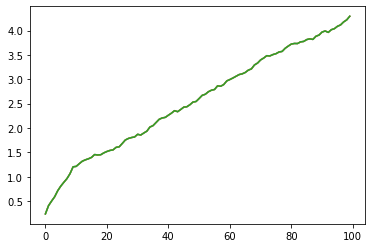

In [76]:
b.plot_cumulative_regret()
# cum_regret = {}

arr = np.empty(b.episodes['rewards'].shape).T
arr[:,:] = np.max(b.episodes['bandits'], axis = 1)
regret = np.cumsum((arr.T - b.episodes['rewards']).mean(0))
plt.plot(regret)

# reg = np.cumsum(b.env.bandit.max() - b.episodes['rewards'].mean(0))
plt.plot(regret)
# reg = np.cumsum((arr - b.episodes['rewards']).mean(0))
# reg
# # reg_df['hh'] = reg
# # reg_df[['he', 'hm', 'hh']].plot()
# # b.plot_actions()
# # b.episodes['rewards'].mean(0)
# plt.plot(reg);
# b['rewards'][0]
# plt.plot(reg)

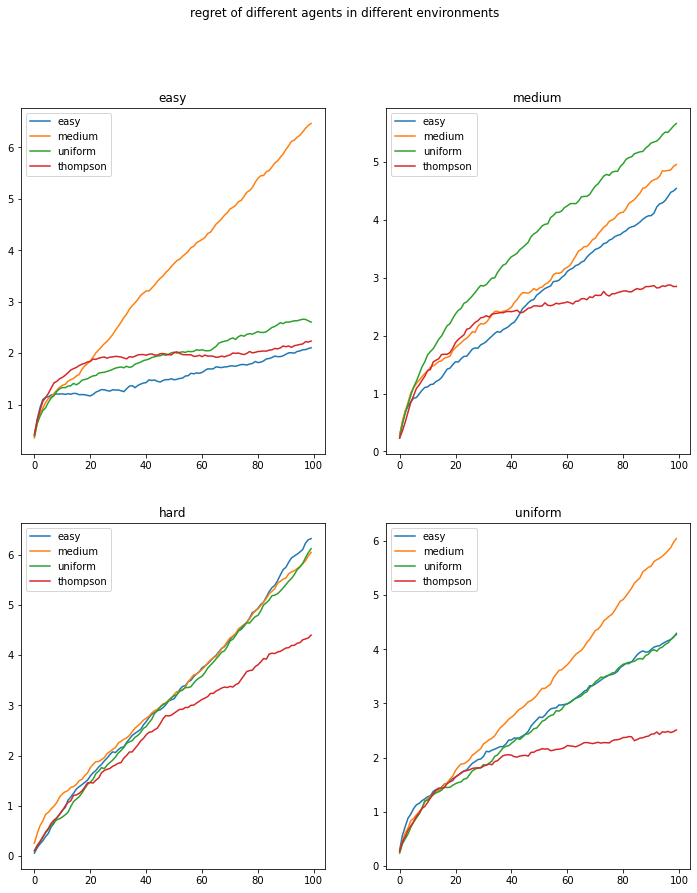

In [82]:
# reg_df['uu'] = regret
# reg_df = pd.read_csv('regret_bandits.csv')
# reg_df.to_csv('regret_bandits.csv')
plt.figure(figsize=(12, 14))
plt.suptitle('regret of different agents in different environments')
plt.subplot(221)
labels = ['easy', 'medium','uniform', 'thompson']
for p in [reg_df[['ee','em', 'eu','eT']]]:
    plt.plot(p);
plt.legend(labels);
plt.title('easy')
plt.subplot(222)
for p in [reg_df[['me','mm','mu','mT']]]:
    plt.plot(p);
plt.legend(labels);
plt.title('medium')
plt.subplot(223)
for p in [reg_df[['he','hm','hu','hT']]]:
    plt.plot(p);
plt.legend(labels);
plt.title('hard')
plt.subplot(224)
for p in [reg_df[['ue','um','uu', 'uT']]]:
    plt.plot(p);
plt.legend(labels)
plt.title('uniform')
plt.savefig('regret of different agents in different environments wo hard.pdf')
#     plt.legend(labels);
# plt.rcParams['figure.figsize'] = [10,10]
# reg_df[['ee','em','eT']].plot()
# # plt.subplot(132)
# reg_df[['me','mm','mT']].plot()
# # plt.subplot(133)
# reg_df[['he','hm','hT']].plot();

In [79]:
reg_df.to_csv('regret_bandits.csv')
# b.episode

In [58]:
class ManualBenchmark:
    def __init__(self, agent):
        self.agent = agent
    
    def play(self):
        agent.model.reset_states()
        action, reward, timestep, done = 0, 0, 1, 0
#         actions, rewards, values = [] * 3
        while reward >= 0:
            # action and reward at t - 1 and timestep at t
            action, value, _ = agent._predict(action, reward, timestep)
            reward = input(f"LSTM chose {action}, give me a reward 0 or 1 (-1 ends the game)")
            reward = int(reward)
            # rewards, values and actions at t
#             rewards.append(reward)
#             actions.append(action)
#             values.append(value)
            timestep += 1
        return actions, rewards, values

In [59]:
mb = ManualBenchmark(agent)

In [60]:
mb.play()

LSTM chose [0], give me a reward 0 or 1 (-1 ends the game) 0
LSTM chose [1], give me a reward 0 or 1 (-1 ends the game) 1
LSTM chose [0], give me a reward 0 or 1 (-1 ends the game) 0
LSTM chose [1], give me a reward 0 or 1 (-1 ends the game) 1
LSTM chose [1], give me a reward 0 or 1 (-1 ends the game) 1
LSTM chose [1], give me a reward 0 or 1 (-1 ends the game) 1
LSTM chose [1], give me a reward 0 or 1 (-1 ends the game) 0
LSTM chose [0], give me a reward 0 or 1 (-1 ends the game) 0
LSTM chose [1], give me a reward 0 or 1 (-1 ends the game) 1
LSTM chose [1], give me a reward 0 or 1 (-1 ends the game) 0
LSTM chose [1], give me a reward 0 or 1 (-1 ends the game) 0
LSTM chose [1], give me a reward 0 or 1 (-1 ends the game) 0
LSTM chose [1], give me a reward 0 or 1 (-1 ends the game) 0
LSTM chose [1], give me a reward 0 or 1 (-1 ends the game) 0
LSTM chose [1], give me a reward 0 or 1 (-1 ends the game) 0
LSTM chose [1], give me a reward 0 or 1 (-1 ends the game) 0
LSTM chose [1], give me 

KeyboardInterrupt: Interrupted by user